# readme
descrip: plot barotropic stream function in North Atlantic

update history: <br>
v1.0 DL 2021Apr29 <br>
v1.1 DL 2021May10 make publication-ready pics <br>

extra notes: <br>
according to xgcm manual (xgcm-readthedocs-io-en-latest.pdf) page 20, only integrate depth-integrated U velocity in y direction possibly because the interior flow is everywhere westward, see text above grye_4.pdf Eq(15) (http://people.atmos.ucla.edu/jcm/AOS215_site/gyres_3.pdf) <br>

barotropic stream function (follow xgcm manual): <br>
$ U = \int_{-H}^{0} udz  $ <br>
$ \psi = \int_{y_0}^{y} -Udy' $ <br>
H: total water depth

barotropic stream function (BSF) computed using xgcm has dim nlat_t and nlon_u. To regrid BSF for plots, I first compute weight for nlat_u and nlon_u with xesmf, then interpolate BSF to nlat_u and nlon_t and finally regrid interpolated BSF to standard grids for plots. 

# import modules

In [1]:
# general python packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
cartopy.config['pre_existing_data_dir']='/scratch/group/ihesp/shared/cartopy_features'
# import cartopy.crs as ccrs
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid

# python GCM(POP) packages
import xgcm
import pop_tools
import xesmf as xe

# from eofs.xarray import Eof

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.3.49:41907")
client

<Client: 'tcp://10.73.3.49:41907' processes=10 threads=10, memory=210.00 GB>

# read data

In [3]:
# North Atlantic
lat1, lat2 = 20, 65 
lon1, lon2 = -85, -15 # 85W - 15W
outdir='/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'BTstreamFuncNorthAtlantic_2021May06.png'

In [4]:
#TH: transient HR
infile1_TH = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'B.E.13.B.ne120_t12.sehires38.003.sunway.pop.h.1993-2009_UVVEL_2021Apr29/'
    'B.E.13.B.ne120_t12.sehires38.003.sunway.pop.h.1993-2009av_UVVEL_2021Apr29.nc')

infile2_TH = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/'
'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.2084-2100av_UVVEL_2021Apr29.nc')

infile0_TH = ('/scratch/group/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/'
              'ocn/monthly/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1850-01.nc')

chunk_size_HR = {'nlat':400,'nlon':400}
ds_TH=xr.open_mfdataset([infile1_TH,infile2_TH], compat="override", combine="by_coords",
        data_vars="minimal", coords="minimal", chunks=chunk_size_HR,  parallel=True)
ds0_TH = xr.open_dataset(infile0_TH, chunks=chunk_size_HR)
ds_TH

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 2400, nlon: 3600, time: 2, z_t: 62)
Coordinates:
  * time        (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59....
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    UVEL        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    VVEL        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Apr 29 14:24:24 2021: ncra -v UVEL,VVEL B.E.13.BHISTC5...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-09 at 14:10:02.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  32589011
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...

In [5]:
# TL: transient LR
infile1_TL = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'B.E.13.B.ne30g16.sehires38.003.sunway1993-2009/'
    'B.E.13.B.ne30g16.sehires38.003.sunway1993-2009av_UVVEL_2021Apr29.nc')

infile2_TL = ('/scratch/user/dapengli/Projects4iHESP/'
    'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/UVVEL/'
    'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/'
'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.2084-2100av_UVVEL_2021Apr29.nc')

infile0_TL = ('/scratch/group/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/'
        'ocn/monthly/cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1850-01.nc')

chunk_size_LR = {'nlat':384,'nlon':320}

ds_TL=xr.open_mfdataset([infile1_TL,infile2_TL], compat="override", combine="by_coords",
        data_vars="minimal", coords="minimal", chunks=chunk_size_LR,  parallel=True)
ds0_TL = xr.open_dataset(infile0_TL,chunks=chunk_size_LR)
ds_TL

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 2, z_t: 60)
Coordinates:
  * time        (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59....
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    UVEL        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    VVEL        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       Thu Apr 29 16:09:44 2021: ncra -v UVEL,VVEL B.E.13.BHISTC5...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-28 at 12:54:34.0
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  1305625
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...

# data analysis
compute BSF with xgcm

In [6]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["dz", "dz"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],  # areas, technically not needed
} # metrics does not change between LR and HR

In [7]:
ds_TH["DXU"] = ds0_TH.DXU
ds_TH["DXT"] = ds0_TH.DXT
ds_TH["DYU"] = ds0_TH.DYU
ds_TH["DYT"] = ds0_TH.DYT
ds_TH["dz"] = ds0_TH.dz
ds_TH["UAREA"] = ds0_TH.UAREA
ds_TH["TAREA"] = ds0_TH.TAREA
ds_TH["KMU"] = ds0_TH.KMU
ds_TH["KMT"] = ds0_TH.KMT

ds_TL["DXU"] = ds0_TL.DXU
ds_TL["DXT"] = ds0_TL.DXT
ds_TL["DYU"] = ds0_TL.DYU
ds_TL["DYT"] = ds0_TL.DYT
ds_TL["dz"] = ds0_TL.dz
ds_TL["UAREA"] = ds0_TL.UAREA
ds_TL["TAREA"] = ds0_TL.TAREA
ds_TL["KMU"] = ds0_TL.KMU
ds_TL["KMT"] = ds0_TL.KMT

ds_TH

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 2400, nlon: 3600, time: 2, z_t: 62)
Coordinates:
  * time        (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59....
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    UVEL        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    VVEL        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    DXU         (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    DXT         (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    DYU         (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    DYT         (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    UAREA       (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    KMU         (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Apr 29 14:24:24 2021: ncra -v UVEL,VVEL B.E.13.BHISTC5...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-09 at 14:10:02.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  32589011
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...

In [8]:
# xgcm metrics
grid_TH, xds_TH = pop_tools.to_xgcm_grid_dataset(ds_TH, periodic=True, metrics=metrics)
grid_TL, xds_TL = pop_tools.to_xgcm_grid_dataset(ds_TL, periodic=True, metrics=metrics)
xds_TH

<xarray.Dataset>
Dimensions:     (d2: 2, nlat_t: 2400, nlat_u: 2400, nlon_t: 3600, nlon_u: 3600, time: 2, z_t: 62)
Coordinates:
  * time        (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59....
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG       (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    ULAT        (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLONG       (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLAT        (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
  * nlon_u      (nlon_u) int64 1 2 3 4 5 6 7 ... 3595 3596 3597 3598 3599 3600
  * nlat_u      (nlat_u) int64 1 2 3 4 5 6 7 ... 2395 2396 2397 2398 2399 2400
  * nlon_t      (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t      (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
Dimensions without coordinates: d2
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    UVEL        (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    VVEL        (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    DXU         (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    DXT         (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    DYU         (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    DYT         (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    UAREA       (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TAREA       (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    KMU         (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    KMT         (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Apr 29 14:24:24 2021: ncra -v UVEL,VVEL B.E.13.BHISTC5...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-09 at 14:10:02.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  32589011
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...

In [9]:
U_bt_TH = -grid_TH.integrate(xds_TH.UVEL,'Z') # bt: barotropic 
psi_TH = grid_TH.cumint(U_bt_TH,'Y', boundary='fill')
psi_TH = psi_TH/1e2/1e4/1e6 # convert unit, UVEL is cm/s, dz,DYU are cm, 1Sv=10^6m^3
psi_TH = psi_TH.rename('BSF')
psi_TH.attrs['long_name'] = 'Barotropic Stream function'
psi_TH.attrs['units'] = 'Sv'

U_bt_TL = -grid_TL.integrate(xds_TL.UVEL,'Z')
psi_TL = grid_TL.cumint(U_bt_TL,'Y', boundary='fill')
psi_TL = psi_TL/1e2/1e4/1e6 # convert unit, UVEL is cm/s, dz,DYU are cm, 1Sv=10^6m^3
psi_TL = psi_TL.rename('BSF')
psi_TL.attrs['long_name'] = 'Barotropic Stream function'
psi_TL.attrs['units'] = 'Sv'

psi_TH # psi is nlat_t, nlon_u

<xarray.DataArray 'BSF' (time: 2, nlat_t: 2400, nlon_u: 3600)>
dask.array<truediv, shape=(2, 2400, 3600), dtype=float64, chunksize=(1, 400, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59.999987
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 3594 3595 3596 3597 3598 3599 3600
Attributes:
    long_name:  Barotropic Stream function
    units:      Sv

In [10]:
# mask land points
mask_TH = grid_TH.interp(xds_TH.KMU, 'Y')
mask_TL = grid_TL.interp(xds_TL.KMU, 'Y')
mask_TH # mask is nlat_t, nlon_u

<xarray.DataArray 'mul-5b1978667b0f2e9b49bf5de5ac7f4d28' (nlat_t: 2400, nlon_u: 3600)>
dask.array<mul, shape=(2400, 3600), dtype=float64, chunksize=(399, 400), chunktype=numpy.ndarray>
Coordinates:
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 3594 3595 3596 3597 3598 3599 3600

In [11]:
psi_TL = psi_TL.where(mask_TL>0,np.nan)
psi_TL = psi_TL.compute()
psi_TL

<xarray.DataArray 'BSF' (time: 2, nlat_t: 384, nlon_u: 320)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [-0., -0., nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [-0., -0., nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59.999987
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 380.5 381.5 382.5 383.5
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
Attributes:
    long_name:  Barotropic Stream function
    units:      Sv

In [12]:
psi_TH = psi_TH.where(mask_TH>0,np.nan)
psi_TH = psi_TH.compute()
psi_TH

<xarray.DataArray 'BSF' (time: 2, nlat_t: 2400, nlon_u: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59.999987
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 3594 3595 3596 3597 3598 3599 3600
Attributes:
    long_name:  Barotropic Stream function
    units:      Sv

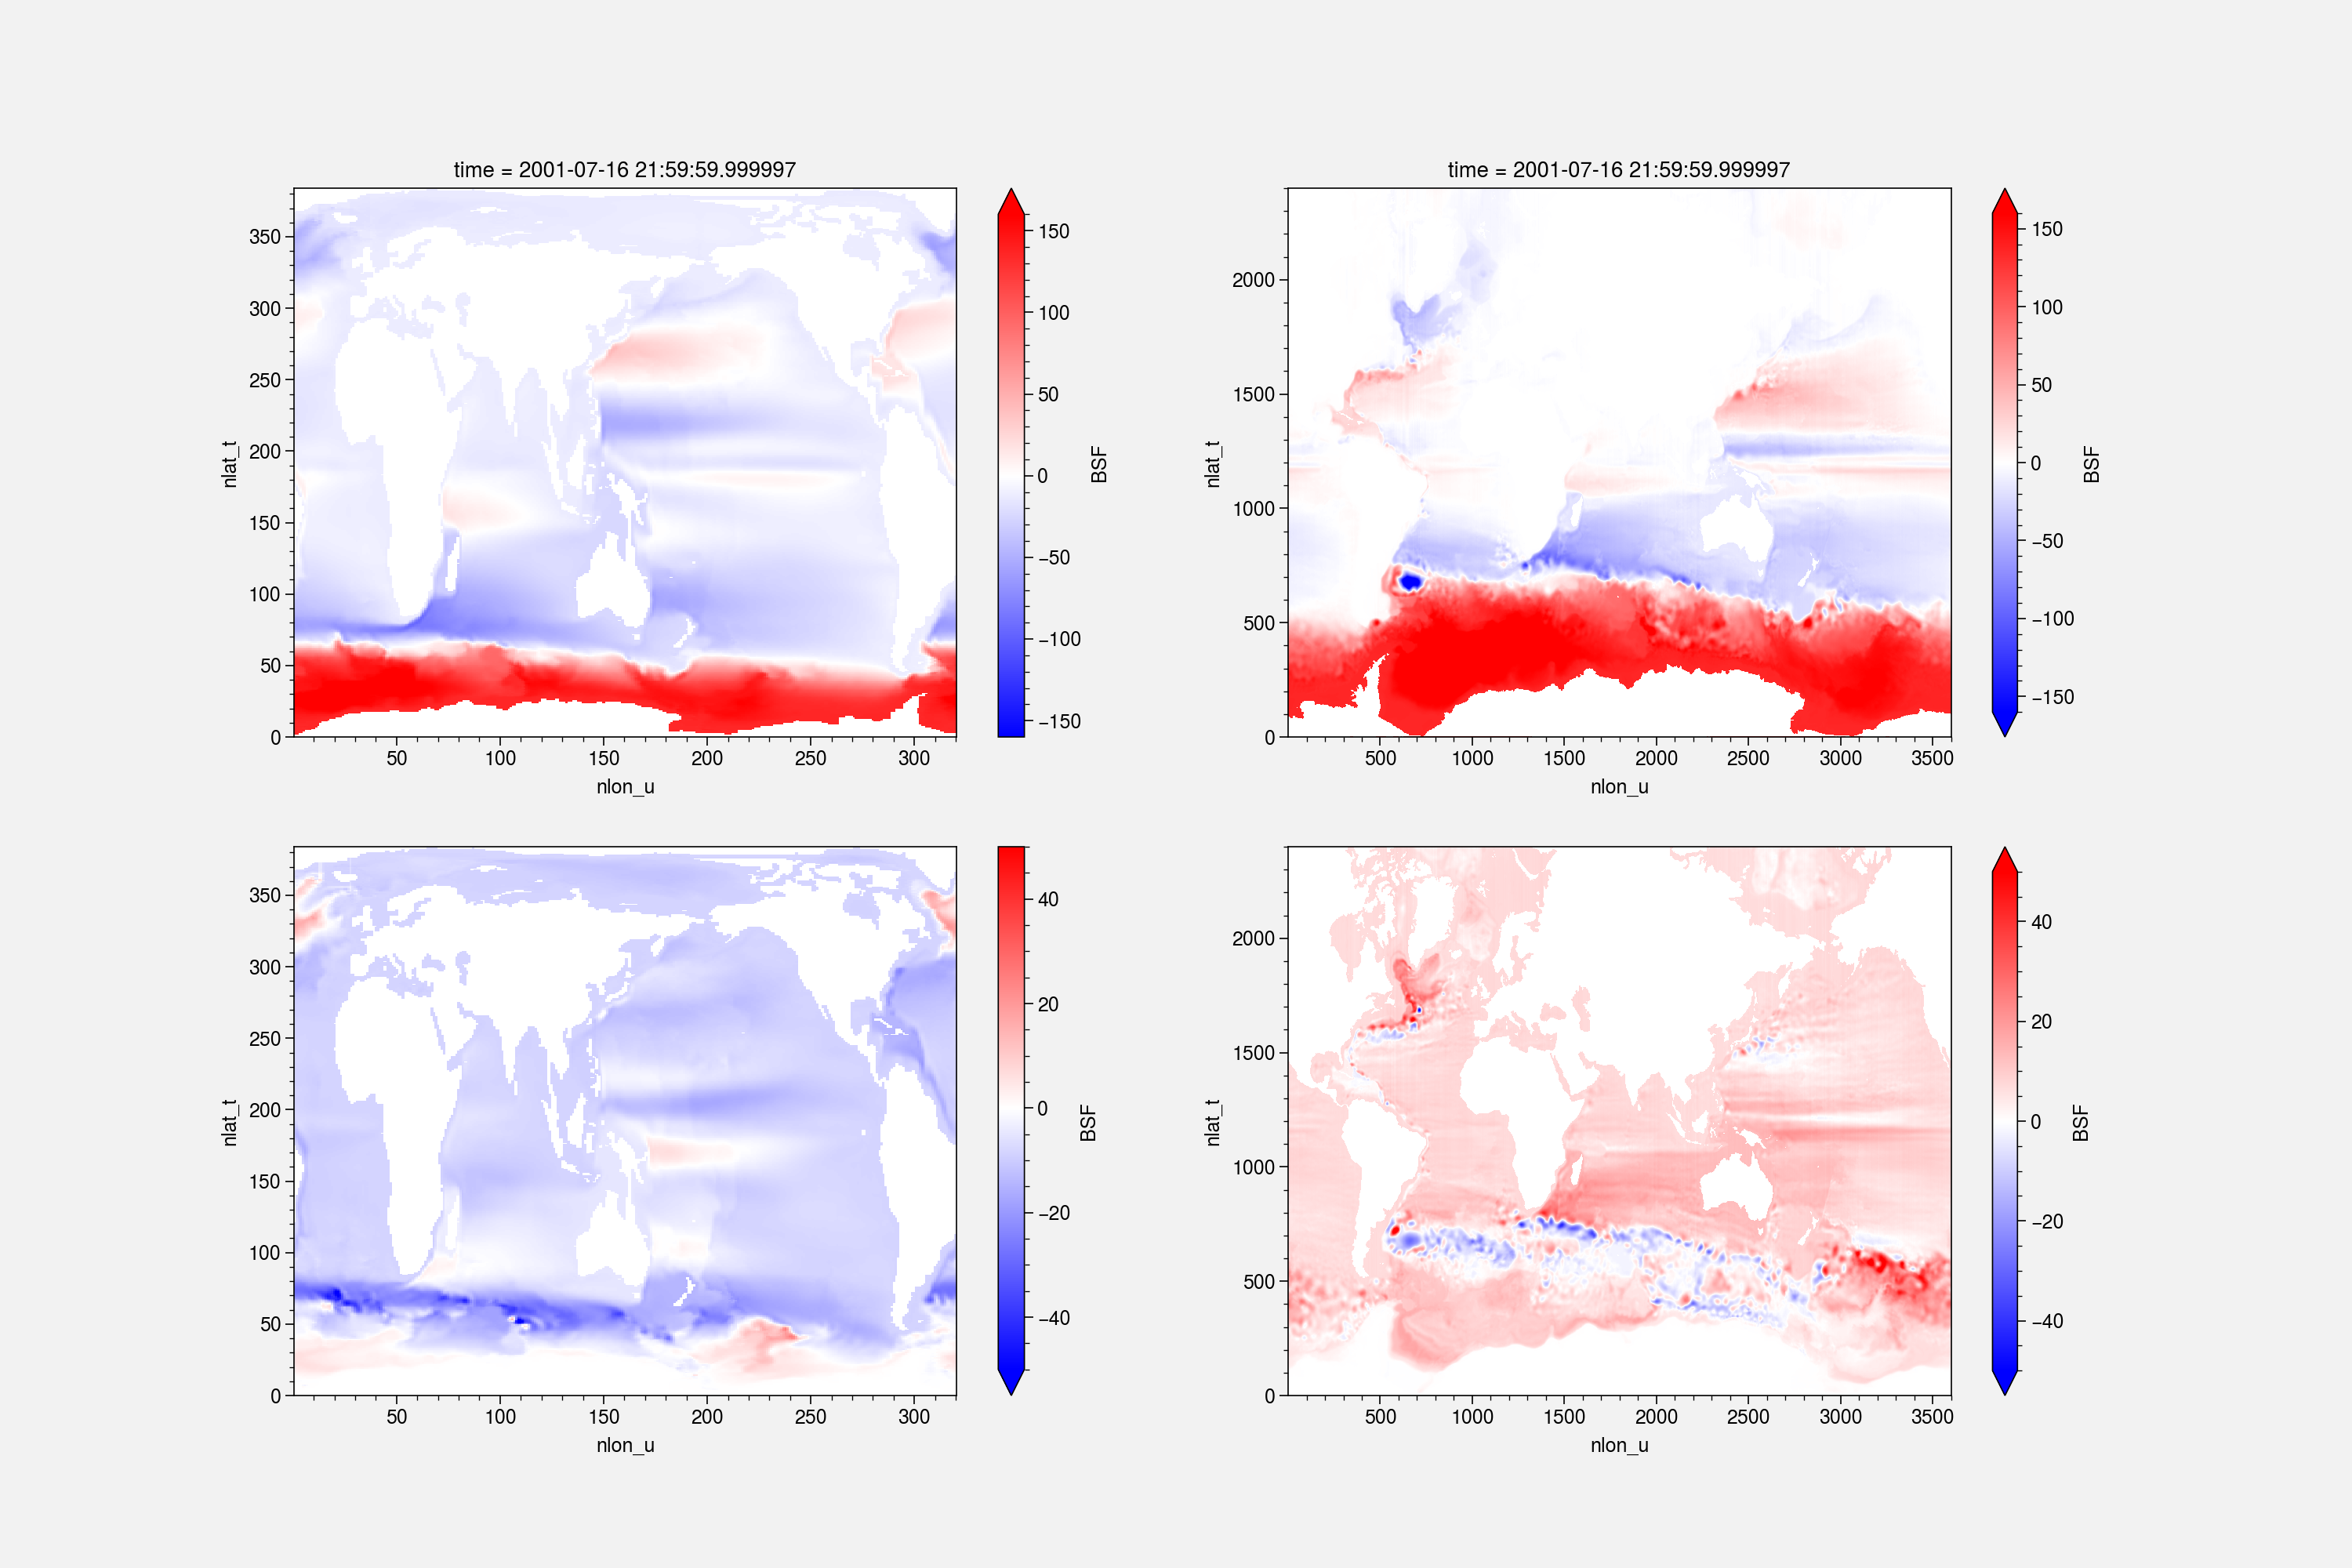

In [13]:
fig, axs= plt.subplots(2,2,figsize=(15,10))
# compare barotropic stream between LR and HR, you can add any constant to psi
(psi_TL+135).isel(time=0).plot(ax=axs[0,0],vmin=-160,vmax=160,cmap='bwr') 
(psi_TH+135).isel(time=0).plot(ax=axs[0,1],vmin=-160,vmax=160,cmap='bwr') 

(psi_TL.isel(time=1)-psi_TL.isel(time=0)).plot(ax=axs[1,0],vmin=-50,vmax=50,cmap='bwr')
(psi_TH.isel(time=1)-psi_TH.isel(time=0)).plot(ax=axs[1,1],vmin=-50,vmax=50,cmap='bwr')

regrid 

In [14]:
# output grid, 1x1 degree rectilinear
ds_1deg = xe.util.grid_global(1, 1)
# ds_1deg

infile0_g16 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds0_g16 = xr.open_dataset(infile0_g16)
# ds0_g16

infile0_t12 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds0_t12 = xr.open_dataset(infile0_t12)
# ds0_t12

grid_t12, xds0_t12 = pop_tools.to_xgcm_grid_dataset(ds0_t12, periodic=True)
xds0_t12
grid_g16, xds0_g16 = pop_tools.to_xgcm_grid_dataset(ds0_g16, periodic=True)
xds0_g16

<xarray.Dataset>
Dimensions:      (nlat_t: 384, nlat_u: 384, nlon_t: 320, nlon_u: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
    TLAT         (nlat_t, nlon_t) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG        (nlat_t, nlon_t) float64 320.6 321.7 322.8 ... 319.4 319.8
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nlon_u       (nlon_u) int64 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * nlat_u       (nlat_u) int64 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * nlon_t       (nlon_t) float64 0.5 1.5 2.5 3.5 ... 316.5 317.5 318.5 319.5
  * nlat_t       (nlat_t) float64 0.5 1.5 2.5 3.5 ... 380.5 381.5 382.5 383.5
Data variables:
    ULAT         (nlat_u, nlon_u) float64 -78.95 -78.95 -78.95 ... 72.41 72.41
    ULONG        (nlat_u, nlon_u) float64 321.1 322.3 323.4 ... 319.6 320.0
    DXT          (nlat_t, nlon_t) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat_t, nlon_t) float64 5.94e+06 5.94e+06 ... 5.046e+06
    TAREA        (nlat_t, nlon_t) float64 1.39e+13 1.39e+13 ... 7.432e+12
    KMT          (nlat_t, nlon_t) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat_t, nlon_t) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 ...
Attributes:
    lateral_dims:         [384 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

In [15]:
xds_ugrid_t12 = xr.Dataset(data_vars={"lon": xds0_t12.ULONG, 
                                      "lat": xds0_t12.ULAT})
xds_ugrid_t12

xds_ugrid_g16 = xr.Dataset(data_vars={"lon": xds0_g16.ULONG, 
                                      "lat": xds0_g16.ULAT})
xds_ugrid_g16

<xarray.Dataset>
Dimensions:  (nlat_u: 384, nlon_u: 320)
Coordinates:
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
Data variables:
    lon      (nlat_u, nlon_u) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    lat      (nlat_u, nlon_u) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41

In [16]:
# --- regrid Uncoupled HR ---
# weightfile_t12_1deg = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#                       'bilinear_t12_1x1degGlobalRectlinear_periodic_2020Aug01.nc')
regridder_xgcm_ugrid_t12_1deg = xe.Regridder(xds_ugrid_t12, ds_1deg, method='bilinear', periodic=True,
         filename='bilinear_xgcm_ugrid_1deg_global_periodic_2021May06.nc') # , reuse_weights=True
# regridder_t12_1deg

# weightfile_g16_1deg = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#                       'bilinear_g16_1x1degGlobalRectlinear_periodic_2020Aug01.nc')
regridder_xgcm_ugrid_g16_1deg = xe.Regridder(xds_ugrid_g16, ds_1deg, method='bilinear', periodic=True,
    filename='bilinear_xgcm_ugrid_1deg_global_periodic_2021May06.nc') #, reuse_weights=True

In [17]:
# interp psi from nlat_t, nlon_u to nlat_u, nlon_t
psi_ugrid_TH = grid_TH.interp(psi_TH, 'Y').rename('BSF')
psi_ugrid_TL = grid_TL.interp(psi_TL, 'Y').rename('BSF')
psi_ugrid_TH

<xarray.DataArray 'BSF' (time: 2, nlat_u: 2400, nlon_u: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59.999987
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 ... 2394 2395 2396 2397 2398 2399 2400
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 3594 3595 3596 3597 3598 3599 3600

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/xesmf/frontend.py:476: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


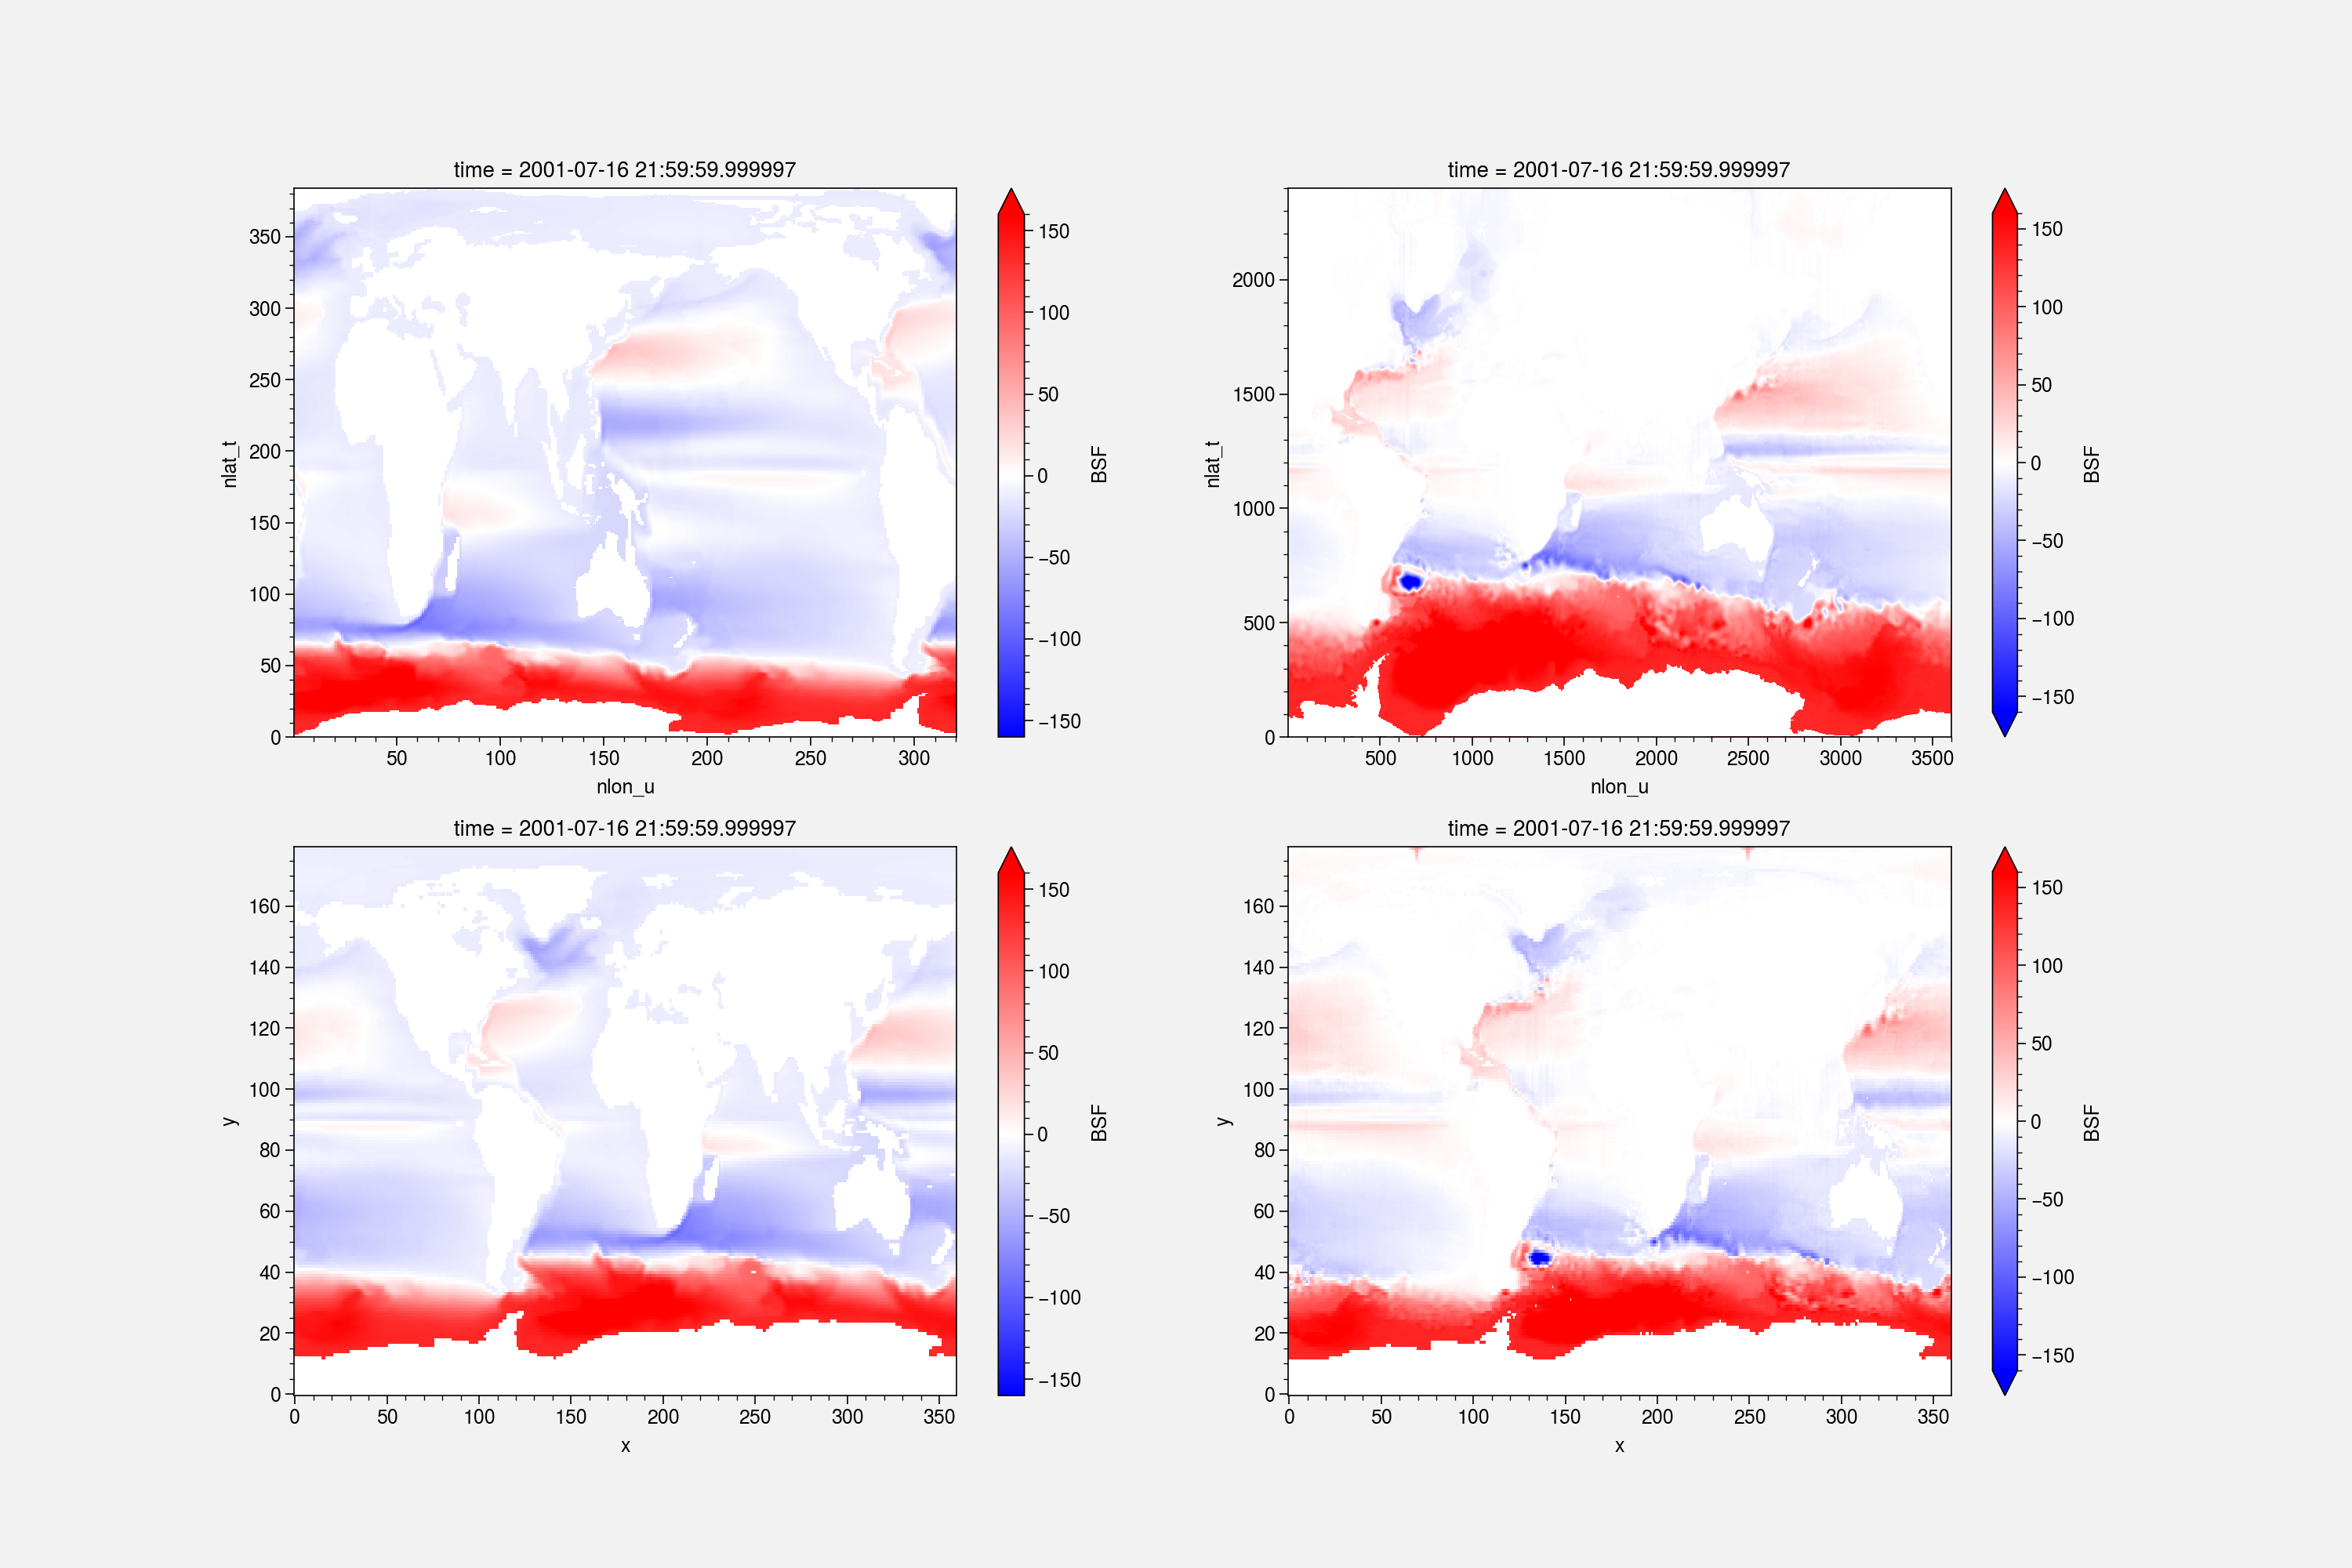

In [18]:
psi_rgd_TH = regridder_xgcm_ugrid_t12_1deg(psi_ugrid_TH)
psi_rgd_TL = regridder_xgcm_ugrid_g16_1deg(psi_ugrid_TL)

fig, axs= plt.subplots(2,2,figsize=(15,10))
(psi_TL+135).isel(time=0).plot(ax=axs[0,0],vmin=-160,vmax=160,cmap='bwr')
(psi_TH+135).isel(time=0).plot(ax=axs[0,1],vmin=-160,vmax=160,cmap='bwr')

# compare regrided barotropic stream between LR and HR, you can add any constant to psi
(psi_rgd_TL+135).isel(time=0).plot(ax=axs[1,0],vmin=-160,vmax=160,cmap='bwr') 
(psi_rgd_TH+135).isel(time=0).plot(ax=axs[1,1],vmin=-160,vmax=160,cmap='bwr') 
# (psi_rgd_TL.isel(time=1)-psi_rgd_TL.isel(time=0)).plot(ax=axs[1,0],vmin=-50,vmax=50,cmap='bwr')
# (psi_rgd_TH.isel(time=1)-psi_rgd_TH.isel(time=0)).plot(ax=axs[1,1],vmin=-50,vmax=50,cmap='bwr')

choose North Atlantic Region

<xarray.DataArray 'BSF' (time: 2, y: 45, x: 70)>
array([[[-102.48019352, -106.28973648, -108.61177971, ...,
         -136.40538363, -137.13885311,           nan],
        [-109.88993333, -110.9730302 ,           nan, ...,
         -136.40725152,           nan,           nan],
        [-111.27403151,           nan, -111.46764413, ...,
         -136.27601224,           nan,           nan],
        ...,
        [-133.56334888,           nan,           nan, ...,
         -150.86879276, -151.64185969, -149.97517222],
        [          nan, -134.56874948, -134.71325629, ...,
         -141.88001955, -142.35937696, -141.74258986],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[-100.72485788, -105.05354213, -106.68132631, ...,
         -128.84526568, -129.2573013 ,           nan],
        [-107.77671544, -108.48177148,           nan, ...,
         -128.82730306,           nan,           nan],
        [-108.78496172,           nan, -108.83638866, ...,
         -128.59251563,           nan,           nan],
        ...,
        [-127.44275483,           nan,           nan, ...,
         -143.8231586 , -144.50593752, -143.0657302 ],
        [          nan, -127.70759396, -127.65099069, ...,
         -135.59744831, -135.87742141, -135.3351555 ],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]])
Coordinates:
  * time     (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59.999987
    lon      (y, x) float64 -84.5 -83.5 -82.5 -81.5 ... -18.5 -17.5 -16.5 -15.5
    lat      (y, x) float64 20.5 20.5 20.5 20.5 20.5 ... 64.5 64.5 64.5 64.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

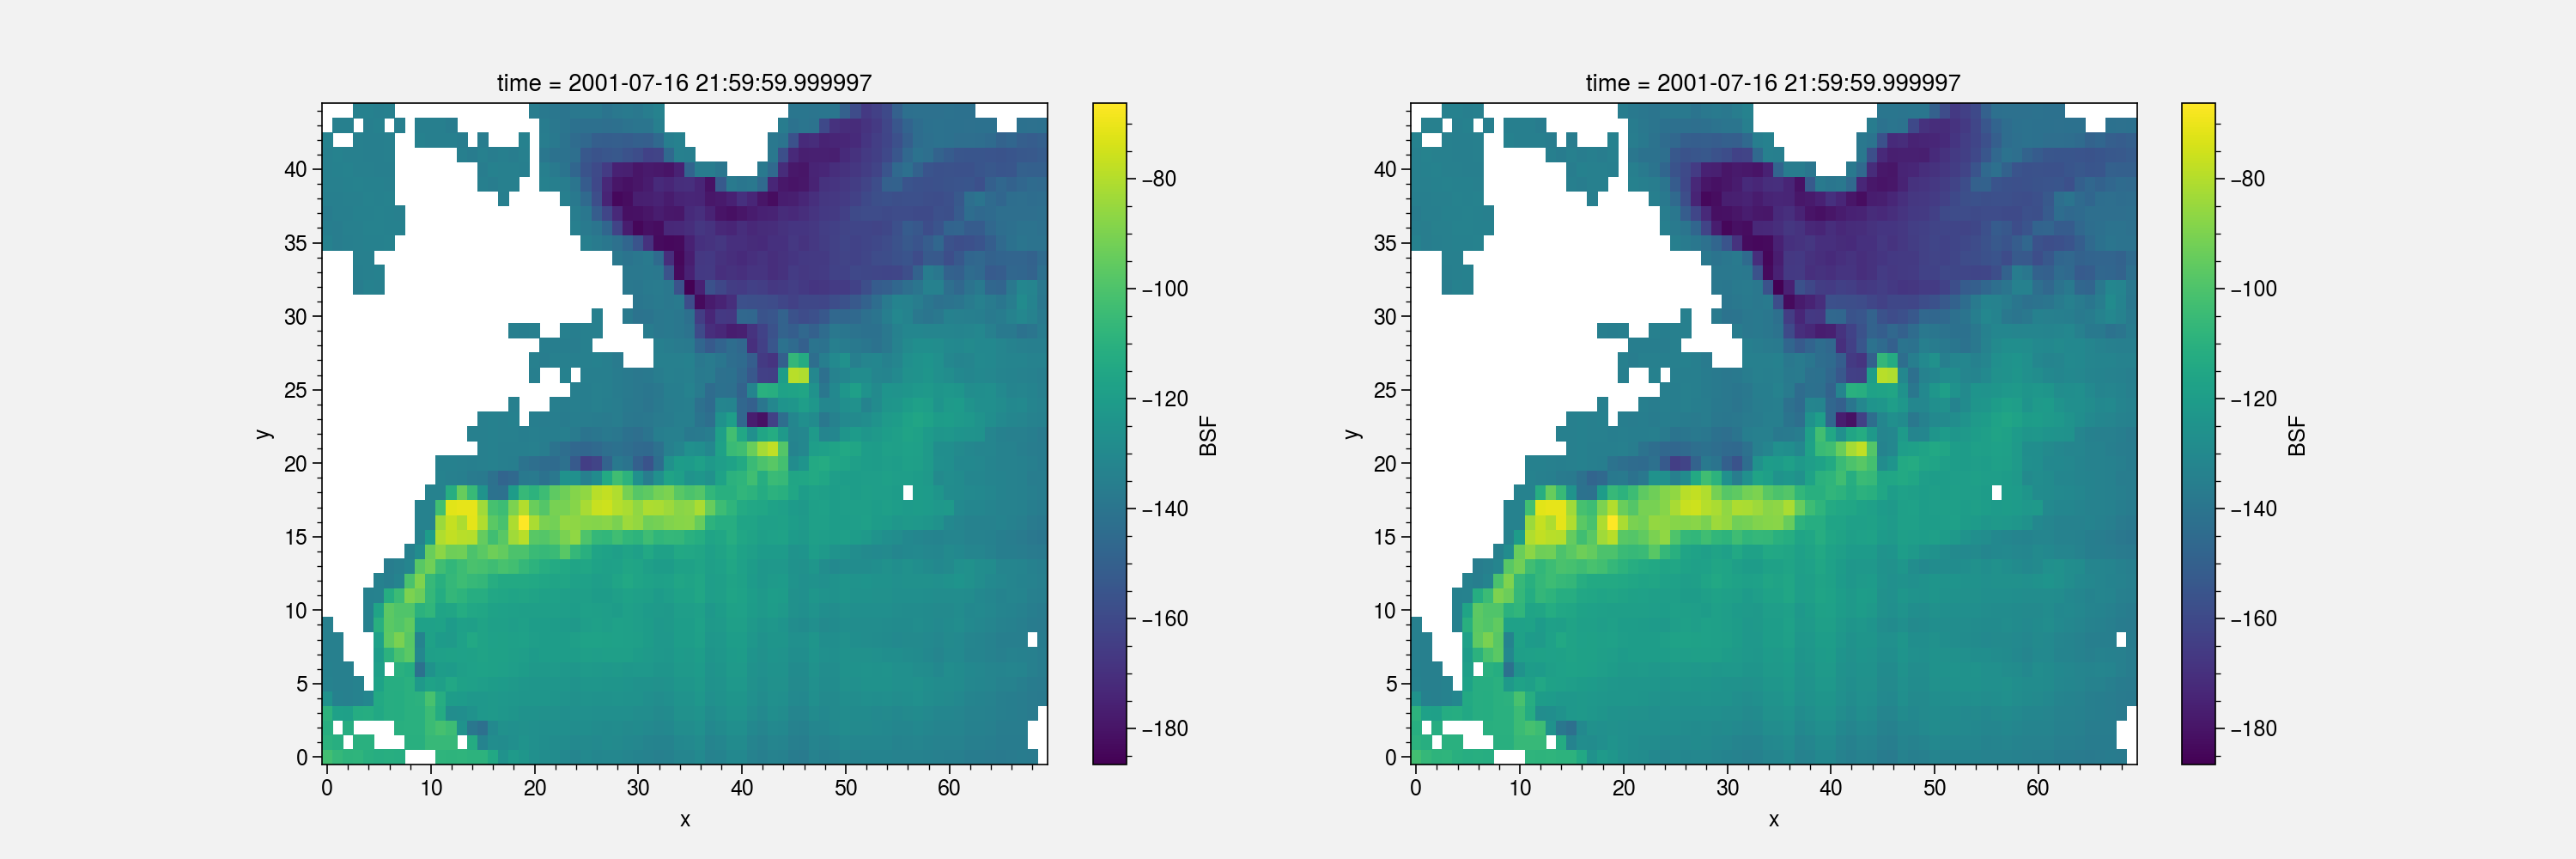

In [19]:
psi_rgd_NA_TL = psi_rgd_TL.where((ds_1deg.lat>lat1) & (ds_1deg.lat<lat2) & 
                                   (ds_1deg.lon>lon1) & (ds_1deg.lon<lon2), drop=True)
psi_rgd_NA_TH = psi_rgd_TH.where((ds_1deg.lat>lat1) & (ds_1deg.lat<lat2) & 
                                   (ds_1deg.lon>lon1) &  (ds_1deg.lon<lon2), drop=True)
fig, axs = plt.subplots(1,2,figsize=(15,5))
psi_rgd_NA_TH.isel(time=0).plot(ax=axs[0])
psi_rgd_NA_TH.isel(time=0).plot(ax=axs[1])
psi_rgd_NA_TH

psia is the anomaly of psi with respect to psi in the Africa coast, see vanWestern et al. (2020) method

In [20]:
psia_rgd_NA_TH = psi_rgd_NA_TH - psi_rgd_NA_TH.isel(x=66,y=0) 
# x=67,y=0 correspond to Africa coast, see pic above
psia_rgd_NA_TL = psi_rgd_NA_TL - psi_rgd_NA_TL.isel(x=66,y=0)
psia_rgd_NA_TL

<xarray.DataArray 'BSF' (time: 2, y: 45, x: 70)>
array([[[32.68497996, 32.29387891, 31.04263484, ...,         nan,
                 nan,         nan],
        [31.36481901, 30.3496409 , 29.78305318, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., -5.60435566,
         -5.79164063, -6.12218647],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[28.06617803, 27.08278628, 25.45986712, ...,         nan,
                 nan,         nan],
        [25.94228376, 24.46121716, 23.80347794, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., -3.21254268,
         -3.44969145, -2.82935366],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) object 2001-07-16 21:59:59.999997 2092-07-16 21:59:59.999987
Dimensions without coordinates: y, x

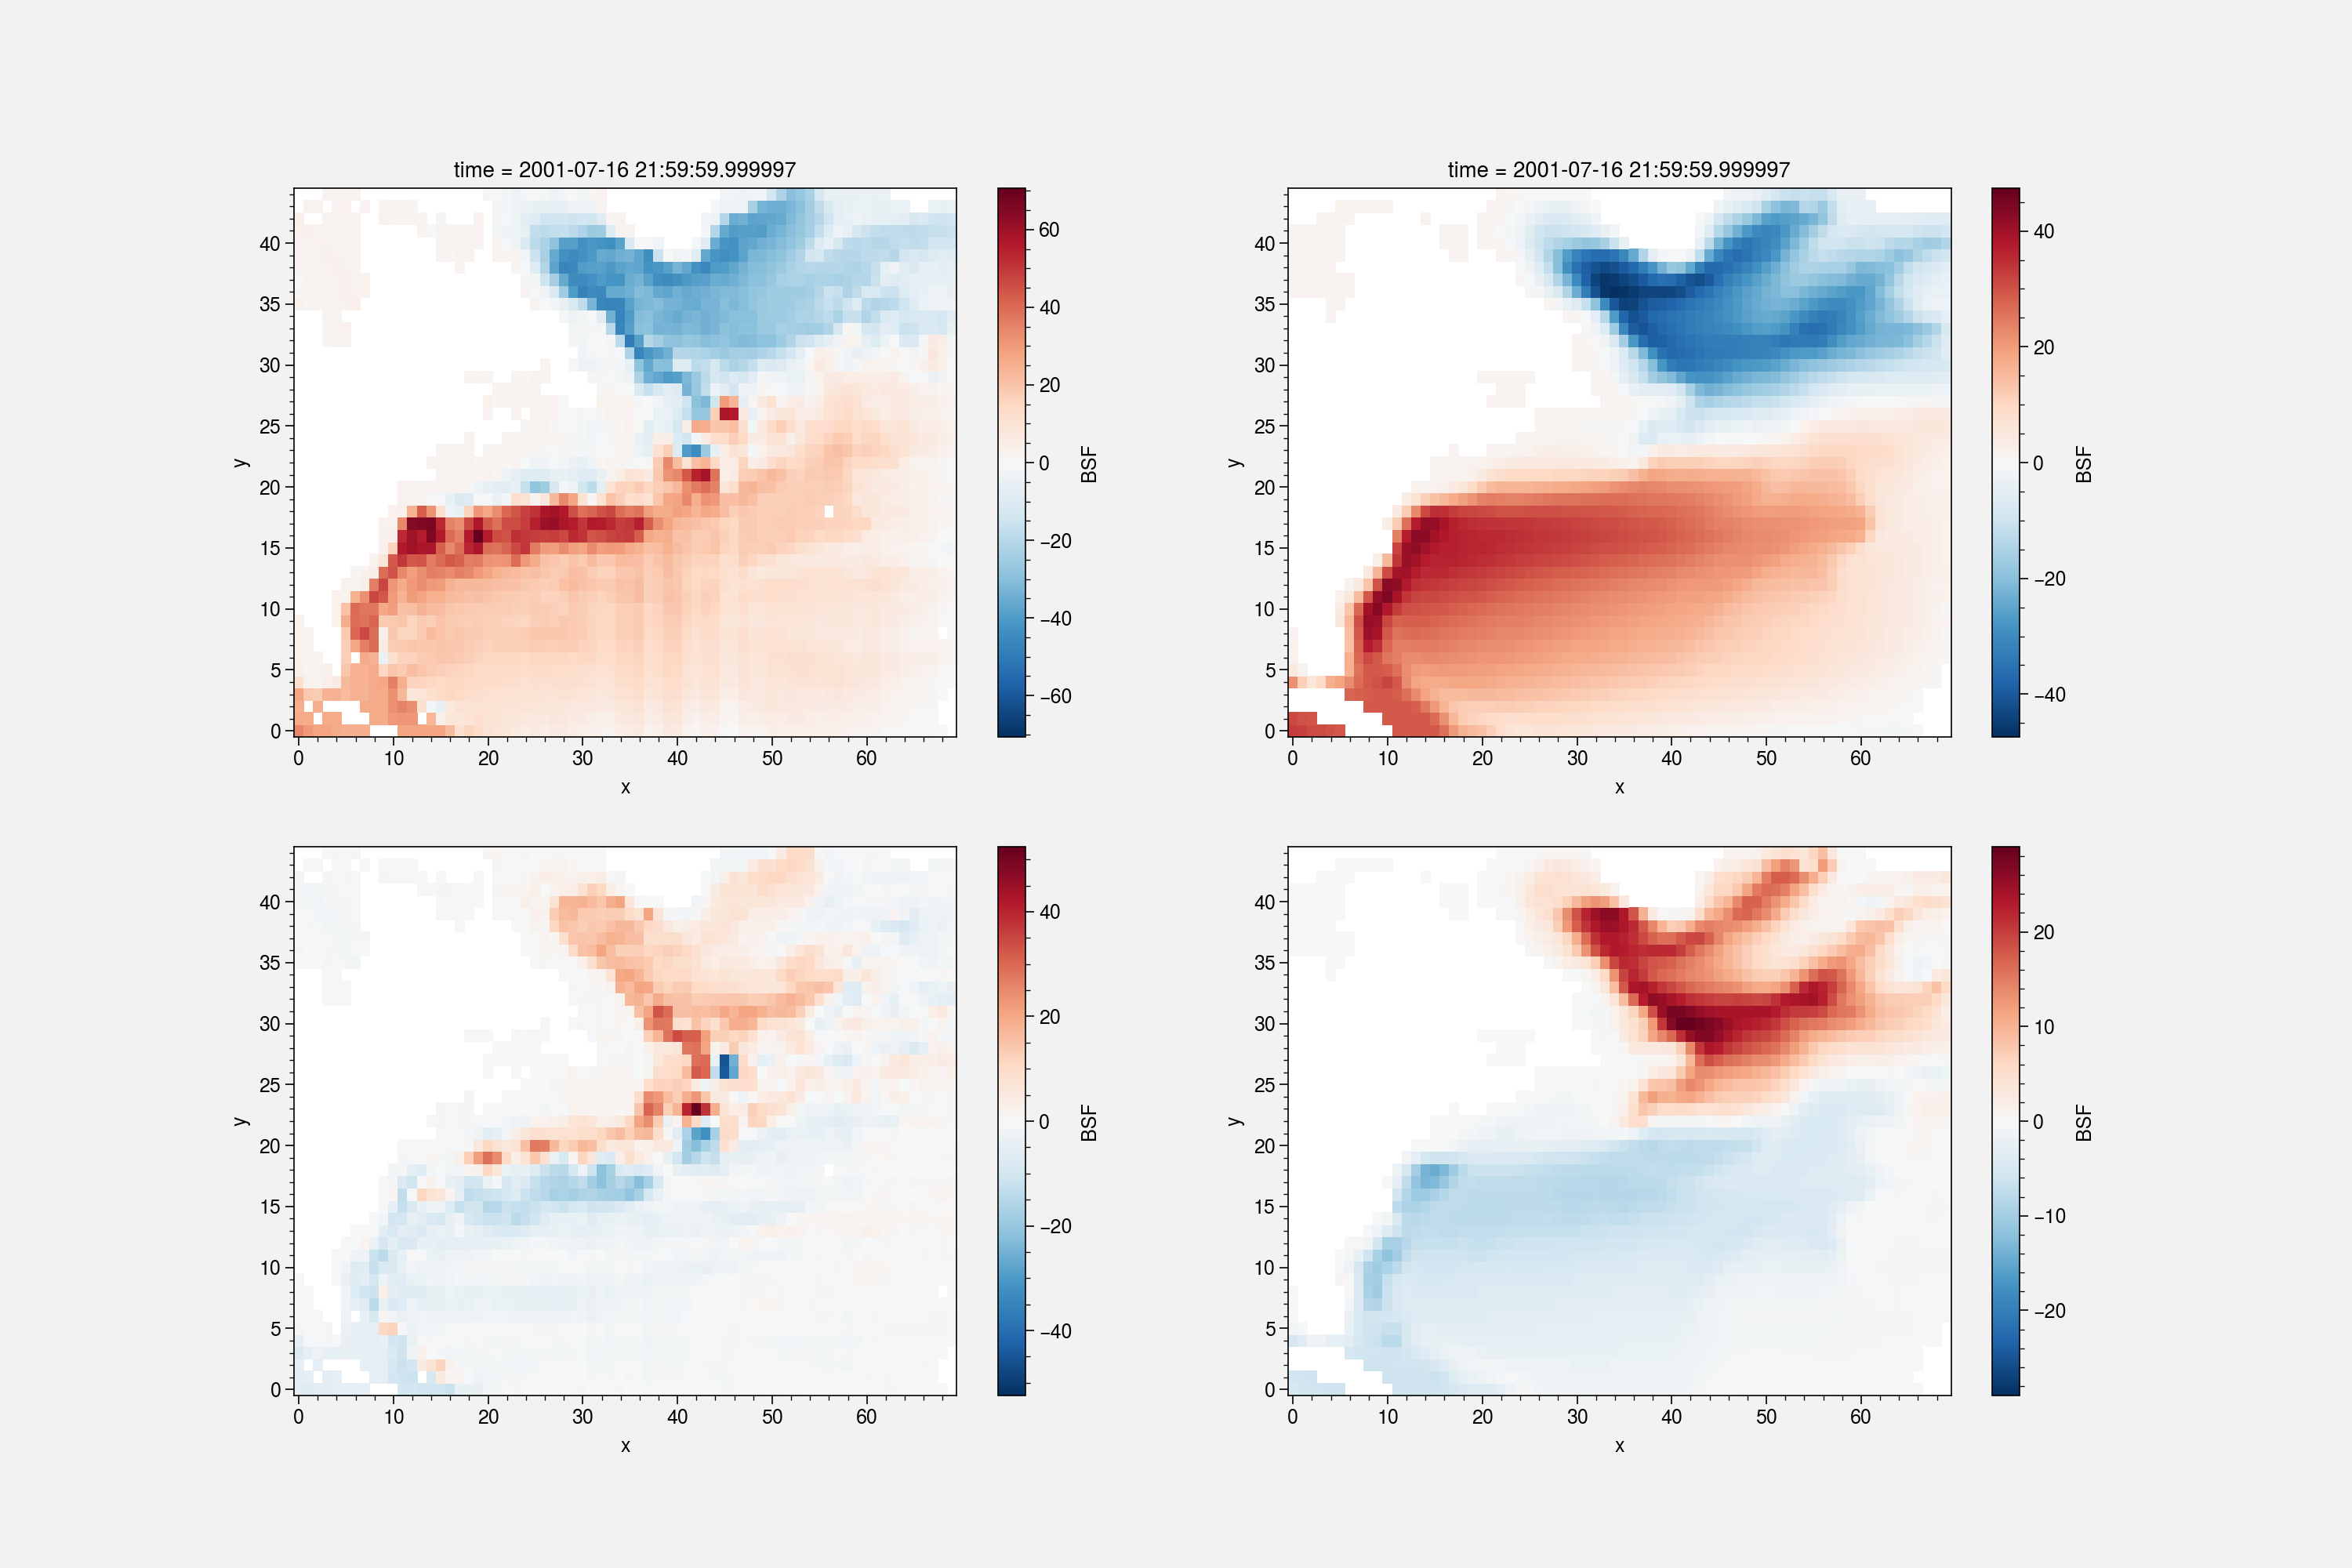

In [21]:
fig, axs= plt.subplots(2,2,figsize=(15,10))
# compare barotropic stream between LR and HR
psia_rgd_NA_TH.isel(time=0).plot(ax=axs[0,0]) 
psia_rgd_NA_TL.isel(time=0).plot(ax=axs[0,1]) 

(psia_rgd_NA_TH.isel(time=1)-psia_rgd_NA_TH.isel(time=0)).plot(ax=axs[1,0])
(psia_rgd_NA_TL.isel(time=1)-psia_rgd_NA_TL.isel(time=0)).plot(ax=axs[1,1])

/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scratch/group/ihesp/shared/conda/envs/envMar25/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super

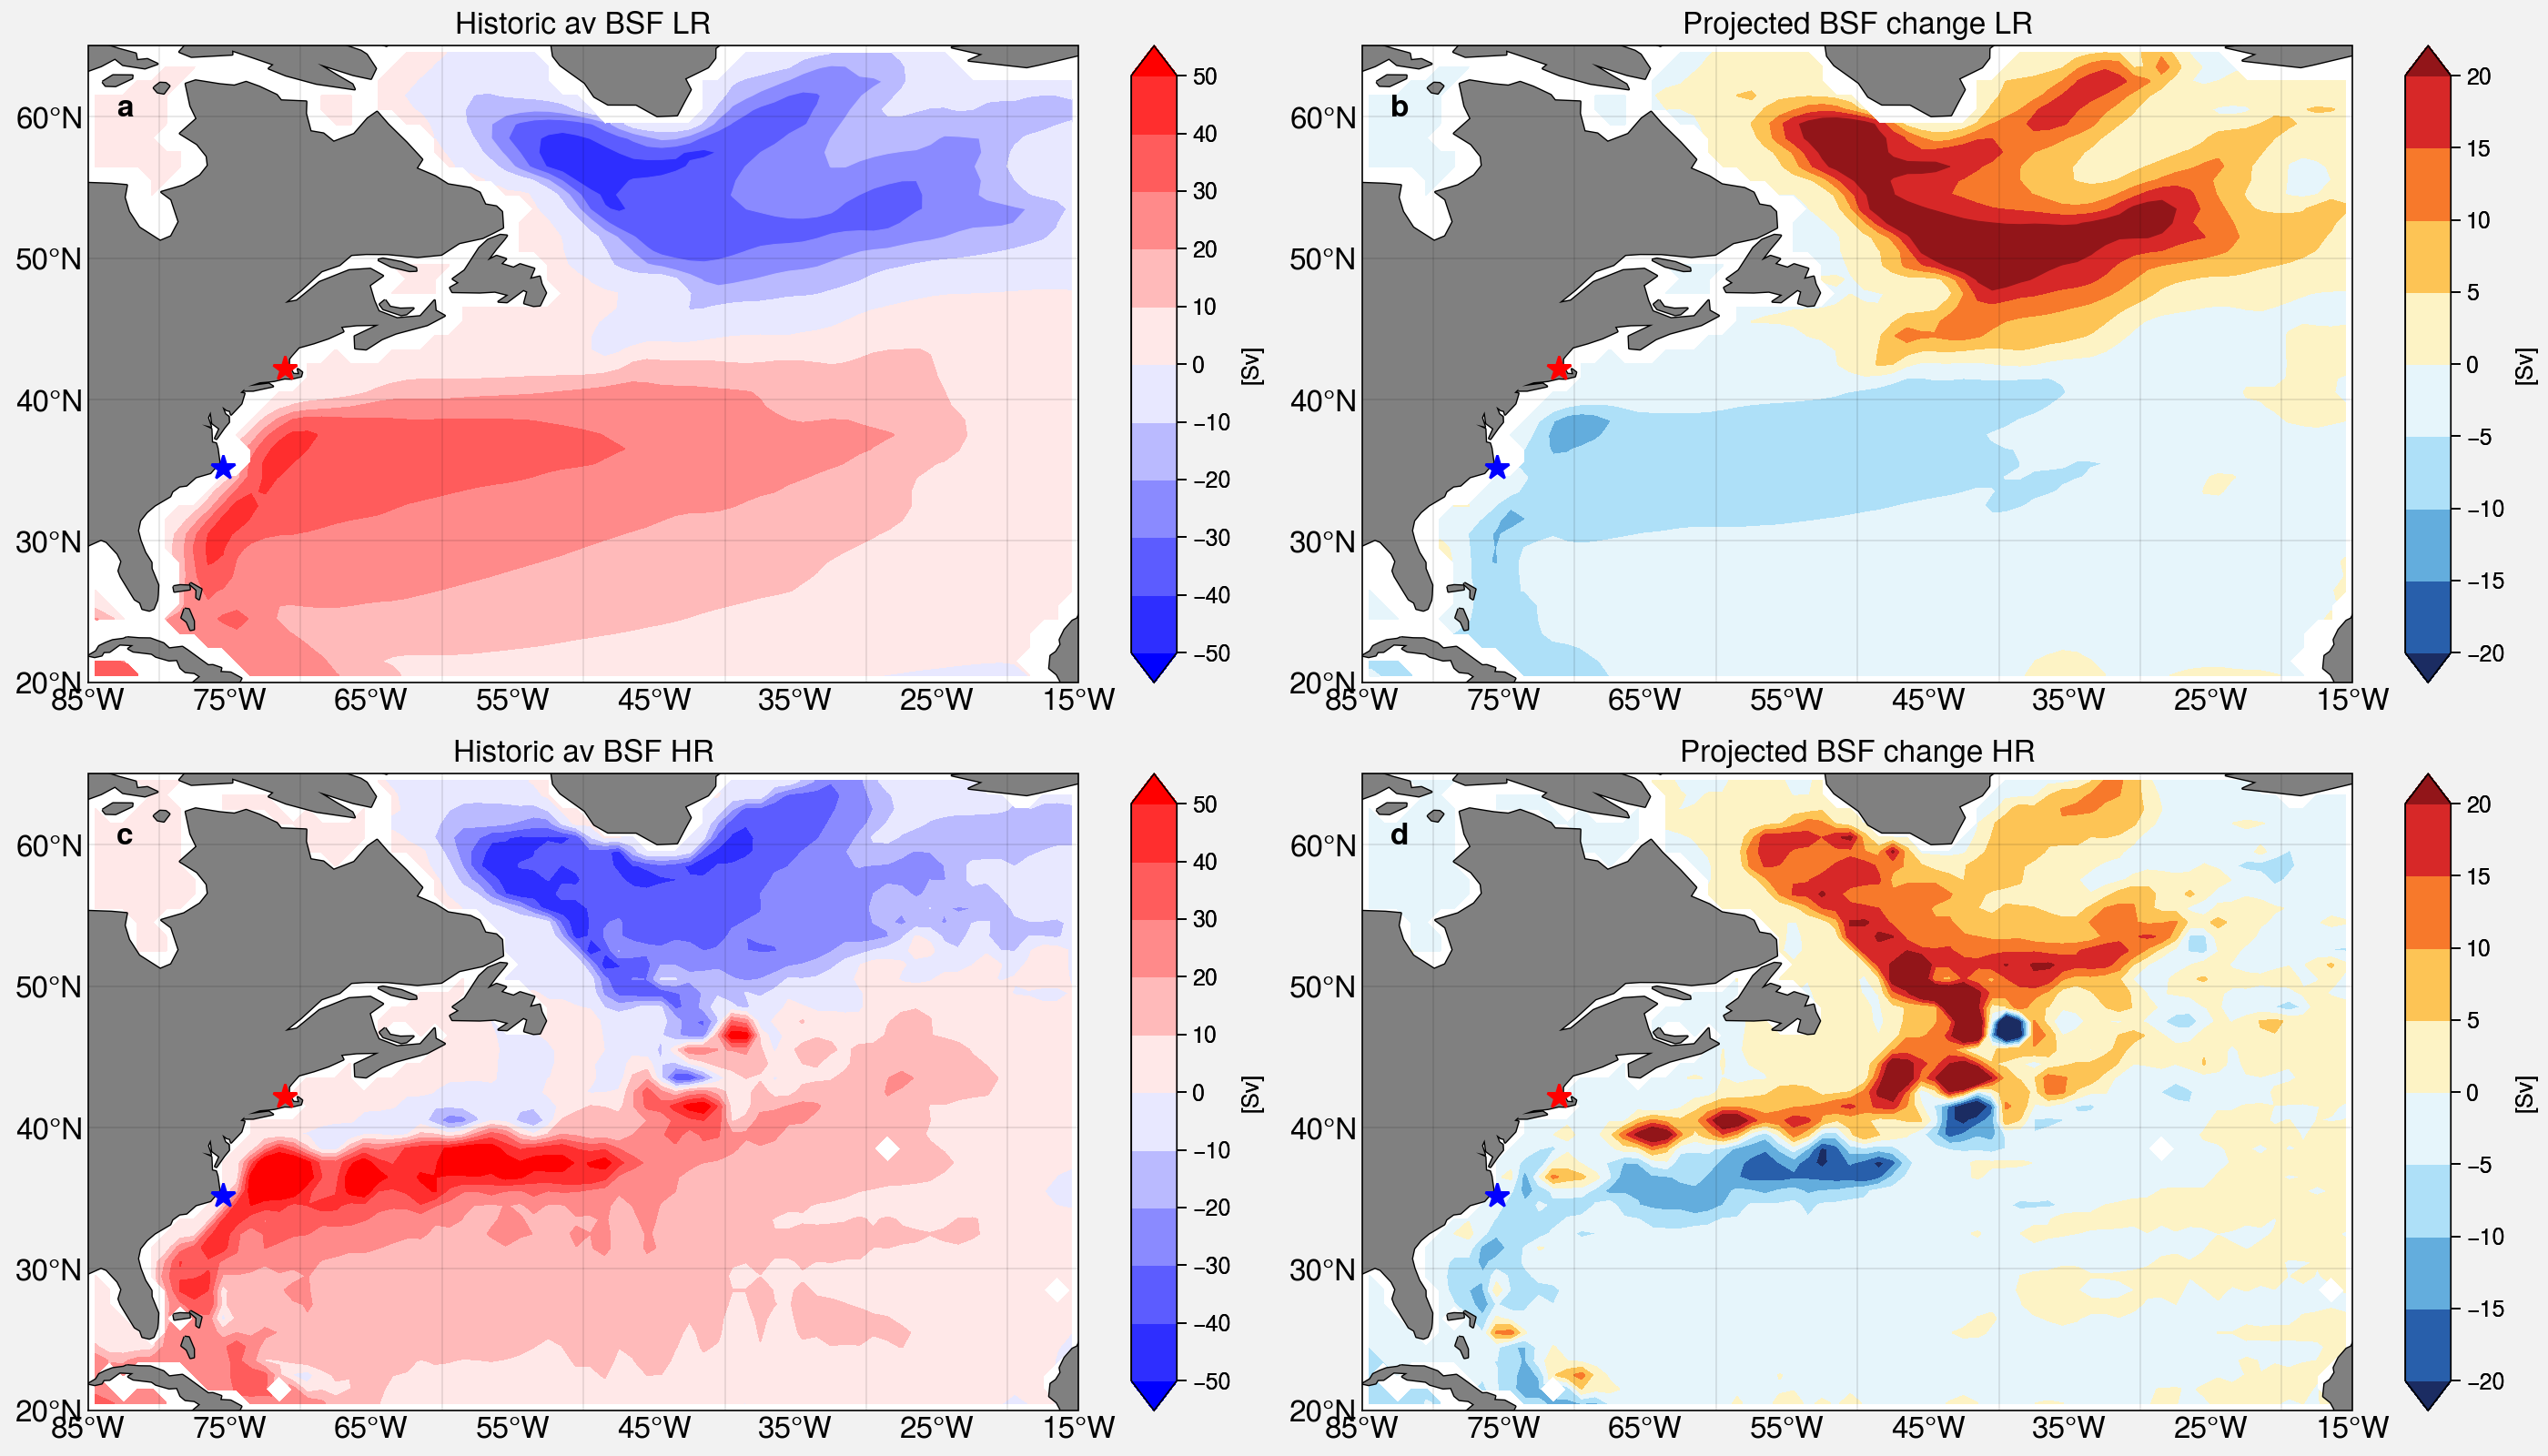

In [22]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='14in',height='8in')

m00=axs[0,0].contourf(psi_rgd_NA_TL.lon,psi_rgd_NA_TL.lat,psia_rgd_NA_TL.isel(time=0),
levels=np.arange(-50,50+1,10),vmin=-50,vmax=50,transform=pc,extend='both',cmap='bwr')
axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Cape Hatters (75.5W, 35.2N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,0].set_xticks(np.arange(-85,-15+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(-85,-15+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[0,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title('Historic av BSF LR', fontsize=12)
axs[0,0].text(-83, 60, 'a', transform=pc, fontsize=12, fontweight='bold')
# Now adding the colorbar
cb = axs[0,0].colorbar(m00,loc='r',label='[Sv]',extend='both',width='2em',shrink=1)

dpsia_rgd_NA_TL = psia_rgd_NA_TL.isel(time=1) - psia_rgd_NA_TL.isel(time=0)
m01=axs[0,1].contourf(psi_rgd_NA_TL.lon, psi_rgd_NA_TL.lat, dpsia_rgd_NA_TL,
levels=np.arange(-20,20+1,5),vmin=-20,vmax=20,transform=pc,extend='both',cmap='ColdHot')
axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Boston (75.5W, 35.2N)
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[0,1].set_xticks(np.arange(-85,-15+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(-85,-15+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[0,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title('Projected BSF change LR', fontsize=12)
axs[0,1].text(-83, 60, 'b', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label='[Sv]', extend='both',width='2em',shrink=1)


m10=axs[1,0].contourf(psi_rgd_NA_TH.lon, psi_rgd_NA_TH.lat, psia_rgd_NA_TH.isel(time=0),
levels=np.arange(-50,50+1,10), vmin=-50, vmax=50, transform=pc, extend='both',cmap='bwr')
axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Boston (75.5W, 35.2N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[1,0].set_xticks(np.arange(-85,-15+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(-85,-15+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[1,0].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title('Historic av BSF HR', fontsize=12)
axs[1,0].text(-83, 60, 'c', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[1,0].colorbar(m10,loc='r', label='[Sv]', extend='both',width='2em',shrink=1)


dpsia_rgd_NA_TH = psia_rgd_NA_TH.isel(time=1) - psia_rgd_NA_TH.isel(time=0)
m11=axs[1,1].contourf(psi_rgd_NA_TH.lon, psi_rgd_NA_TH.lat, dpsia_rgd_NA_TH,
levels=np.arange(-20,20+1,5),vmin=-20,vmax=20,transform=pc,extend='both',cmap='ColdHot')
axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,1].plot(-75.5,35.2,transform=pc,marker='*',color='b',markersize=10)
# Boston (75.5W, 35.2N)
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1, lon2, lat1, lat2], crs=pc)
axs[1,1].set_xticks(np.arange(-85,-15+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(-85,-15+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(20,60+1,10), crs=pc)
axs[1,1].set_yticklabels(np.arange(20,60+1,10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title('Projected BSF change HR', fontsize=12)
axs[1,1].text(-83, 60, 'd', transform=pc, fontsize=12, fontweight='bold')
# add colorbar
cb = axs[1,1].colorbar(m11, loc='r', label='[Sv]', extend='both',width='2em',shrink=1)

fig1.savefig(pic1,bbox_inches='tight')

# Appendix
compute barotropic stream function for LR and HR files <br>
LR

In [5]:
infile0_TL = ('/scratch/group/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/'
'ocn/monthly/cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1928-01.nc')
ds0_TL = xr.open_dataset(infile0_TL,chunks={'nlat':384,'nlon':80})
ds0_TL

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, nlat: 384, nlon: 320, time: 1, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/14)
  * time                  (time) object 1928-02-01 00:00:00
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ...                    ...
    transport_components  (transport_comp, nchar) |S1 dask.array<chunksize=(5, 256), meta=np.ndarray>
    transport_regions     (transport_reg, nchar) |S1 dask.array<chunksize=(2, 256), meta=np.ndarray>
    ULONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    ULAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
Dimensions without coordinates: d2, moc_comp, nchar, nlat, nlon, transport_comp, transport_reg
Data variables: (12/137)
    time_bound            (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    moc_components        (moc_comp, nchar) |S1 dask.array<chunksize=(3, 256), meta=np.ndarray>
    dz                    (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                   (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                   (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    KMU                   (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    ...                    ...
    XBLT                  (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 80), meta=np.ndarray>
    TBLT                  (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 80), meta=np.ndarray>
    BSF                   (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 80), meta=np.ndarray>
    MOC                   (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 3, 61, 395), meta=np.ndarray>
    N_HEAT                (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
    N_SALT                (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-20 at 01:47:00.1
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  712500
    tavg_sum:      2678400.0

make ds xgcm-compatible 

In [6]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["dz", "dz"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],  # areas, technically not needed
}

In [7]:
# xgcm metrics
grid_TL, xds0_TL = pop_tools.to_xgcm_grid_dataset(ds0_TL, periodic=True, metrics=metrics)
xds0_TL

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, nlat_t: 384, nlat_u: 384, nlon_t: 320, nlon_u: 320, time: 1, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/17)
  * time                  (time) object 1928-02-01 00:00:00
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                    ...
    TLONG                 (nlat_t, nlon_t) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    TLAT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
  * nlon_u                (nlon_u) int64 1 2 3 4 5 6 ... 315 316 317 318 319 320
  * nlat_u                (nlat_u) int64 1 2 3 4 5 6 ... 379 380 381 382 383 384
  * nlon_t                (nlon_t) float64 0.5 1.5 2.5 3.5 ... 317.5 318.5 319.5
  * nlat_t                (nlat_t) float64 0.5 1.5 2.5 3.5 ... 381.5 382.5 383.5
Dimensions without coordinates: d2, moc_comp, nchar, transport_comp, transport_reg
Data variables: (12/137)
    time_bound            (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    moc_components        (moc_comp, nchar) |S1 dask.array<chunksize=(3, 256), meta=np.ndarray>
    dz                    (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                   (z_w_top) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                   (nlat_t, nlon_t) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    KMU                   (nlat_u, nlon_u) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    ...                    ...
    XBLT                  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 384, 80), meta=np.ndarray>
    TBLT                  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 384, 80), meta=np.ndarray>
    BSF                   (time, nlat_u, nlon_u) float32 dask.array<chunksize=(1, 384, 80), meta=np.ndarray>
    MOC                   (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 3, 61, 395), meta=np.ndarray>
    N_HEAT                (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
    N_SALT                (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-20 at 01:47:00.1
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  712500
    tavg_sum:      2678400.0

compare two ways of computing depth-integrated U

<xarray.DataArray (time: 1, nlat_u: 384, nlon_u: 320)>
dask.array<neg, shape=(1, 384, 320), dtype=float32, chunksize=(1, 384, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1928-02-01 00:00:00
    ULONG    (nlat_u, nlon_u) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    ULAT     (nlat_u, nlon_u) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384

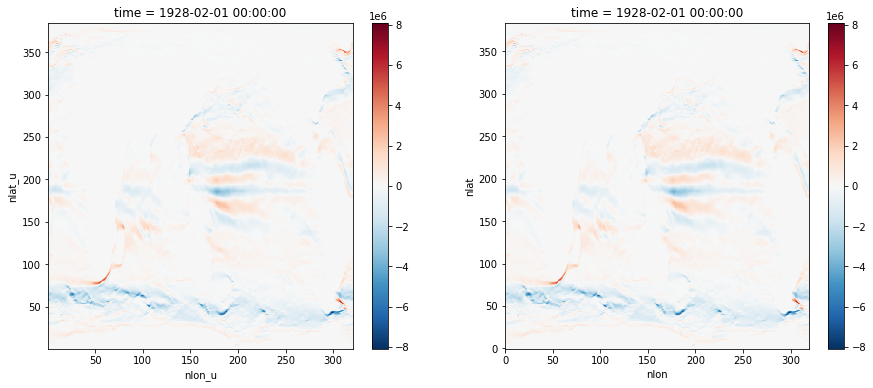

In [8]:
U_bt_x_TL = -grid_TL.integrate(xds0_TL.UVEL,'Z')
U_bt1_TL = -(ds0_TL.UVEL*ds0_TL.dz).sum('z_t')

fig, axs = plt.subplots(1,2,figsize=(15,6))
U_bt_x_TL.squeeze().plot(ax=axs[0])
U_bt1_TL.squeeze().plot(ax=axs[1])
# (U_bt_x.squeeze()-U_bt1.squeeze()).plot(ax=axs[2])
U_bt_x_TL

compute barotropic stream function following xgcm manual page 20

In [9]:
psi_TL = grid_TL.cumint(-grid_TL.integrate(xds0_TL.UVEL,'Z'),'Y', boundary='fill')
psi_TL = psi_TL/1e2/1e4/1e6 # convert unit, UVEL is cm/s, dz,DYU are cm, 1Sv=10^6m^3
psi_TL = psi_TL.rename('BSF')
psi_TL.attrs['long_name'] = 'Barotropic Stream function'
psi_TL.attrs['units'] = 'Sv'

# according to xgcm manual, the command above is equivalent to the command below
# psi2 = grid.cumsum(U_bt_x*xds0_TL.DYU, 'Y', boundary='fill')/1e2/1e4/1e6
# (psi2).where(mask>0).plot.contourf(levels=np.arange(-80, 80+1, 5));
# psi2

psi_TL # psi is nlat_t, nlon_t

<xarray.DataArray 'BSF' (time: 1, nlat_t: 384, nlon_u: 320)>
dask.array<truediv, shape=(1, 384, 320), dtype=float64, chunksize=(1, 383, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1928-02-01 00:00:00
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 380.5 381.5 382.5 383.5
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
Attributes:
    long_name:  Barotropic Stream function
    units:      Sv

make land-mask

In [10]:
mask_TL = grid_TL.interp(xds0_TL.KMU, 'Y')
mask_TL # mask is nlat_t, nlon_u

<xarray.DataArray 'mul-6c209f663ca0c03b5983bdf811cb35f4' (nlat_t: 384, nlon_u: 320)>
dask.array<mul, shape=(384, 320), dtype=float64, chunksize=(383, 80), chunktype=numpy.ndarray>
Coordinates:
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 380.5 381.5 382.5 383.5
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320

In [14]:
psi2_TL = (U_bt_x_TL * xds0_TL.DYU).cumsum('nlon_u')
psi2_TL
psi2_TL.where(xds0_TL.KMU>0)

<xarray.DataArray (time: 1, nlat_u: 384, nlon_u: 320)>
dask.array<where, shape=(1, 384, 320), dtype=float64, chunksize=(1, 384, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1928-02-01 00:00:00
    ULONG    (nlat_u, nlon_u) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    ULAT     (nlat_u, nlon_u) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384

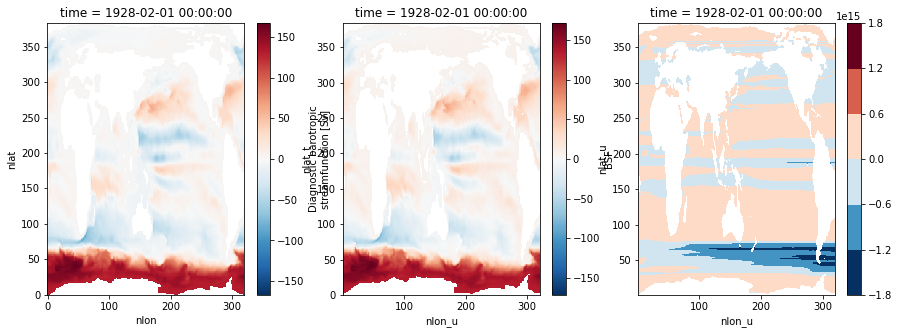

In [15]:
# wrong way to compute barotropic stream function, integrate along Y not nlon_u
psi2 = (U_bt_x_TL * xds0_TL.DYU).cumsum('nlon_u')/1e2/1e4/1e6
fig, axs= plt.subplots(1,3,figsize=(15,5))

ds0_TL.BSF.isel(time=0).plot(ax=axs[0])
(psi_TL+135).isel(time=0).where(mask_TL>0).plot(ax=axs[1]); # you can add psi any constant
psi2_TL.isel(time=0).where(xds0_TL.KMU>0).plot.contourf(ax=axs[2]);

HR

In [16]:
infile0_TH = ('/scratch/group/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/'
              'ocn/monthly/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1928-01.nc')
ds0_TH = xr.open_dataset(infile0_TH,chunks={'nlat':400,'nlon':400})
ds0_TH

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time                (time) object 1928-02-01 00:00:00
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/73)
    time_bound          (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    ...                  ...
    VNT                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    WTT                 (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    UES                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    VNS                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    WTS                 (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    PD                  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-03 at 07:36:51.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  17784611
    tavg_sum:      2678400.0

In [17]:
# xgcm metrics, same as LR
grid_TH, xds0_TH = pop_tools.to_xgcm_grid_dataset(ds0_TH, periodic=True, metrics=metrics)
xds0_TH

<xarray.Dataset>
Dimensions:             (d2: 2, nlat_t: 2400, nlat_u: 2400, nlon_t: 3600, nlon_u: 3600, time: 1, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * time                (time) object 1928-02-01 00:00:00
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    ...                  ...
    TLONG               (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLAT                (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 ... 3596 3597 3598 3599 3600
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 ... 2396 2397 2398 2399 2400
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Dimensions without coordinates: d2
Data variables: (12/73)
    time_bound          (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w_top) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    KMU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    ...                  ...
    VNT                 (time, z_t, nlat_u, nlon_t) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    WTT                 (time, z_w_top, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    UES                 (time, z_t, nlat_t, nlon_u) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    VNS                 (time, z_t, nlat_u, nlon_t) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    WTS                 (time, z_w_top, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
    PD                  (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 62, 400, 400), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-03 at 07:36:51.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  17784611
    tavg_sum:      2678400.0

In [18]:
U_bt_x_TH = -grid_TH.integrate(xds0_TH.UVEL,'Z')
psi_TH = grid_TH.cumint(U_bt_x_TH,'Y', boundary='fill')
psi_TH = psi_TH/1e2/1e4/1e6 # convert unit, UVEL is cm/s, dz,DYU are cm, 1Sv=10^6m^3
psi_TH = psi_TH.rename('BSF')
psi_TH.attrs['long_name'] = 'Barotropic Stream function'
psi_TH.attrs['units'] = 'Sv'

# according to xgcm manual, the command above is equivalent to the command below
# psi2 = grid.cumsum(U_bt_x*xds0_TL.DYU, 'Y', boundary='fill')/1e2/1e4/1e6
# (psi2).where(mask>0).plot.contourf(levels=np.arange(-80, 80+1, 5));
# psi2

psi_TH # psi is nlat_t, nlon_u

<xarray.DataArray 'BSF' (time: 1, nlat_t: 2400, nlon_u: 3600)>
dask.array<truediv, shape=(1, 2400, 3600), dtype=float64, chunksize=(1, 400, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1928-02-01 00:00:00
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 3594 3595 3596 3597 3598 3599 3600
Attributes:
    long_name:  Barotropic Stream function
    units:      Sv

In [23]:
mask_TH = grid_TH.interp(xds0_TH.KMU, 'Y')
mask_TH # mask is nlat_t, nlon_u

<xarray.DataArray 'mul-b5d01329602b0af59966b3ad8b89e996' (nlat_t: 2400, nlon_u: 3600)>
dask.array<mul, shape=(2400, 3600), dtype=float64, chunksize=(399, 400), chunktype=numpy.ndarray>
Coordinates:
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 3594 3595 3596 3597 3598 3599 3600

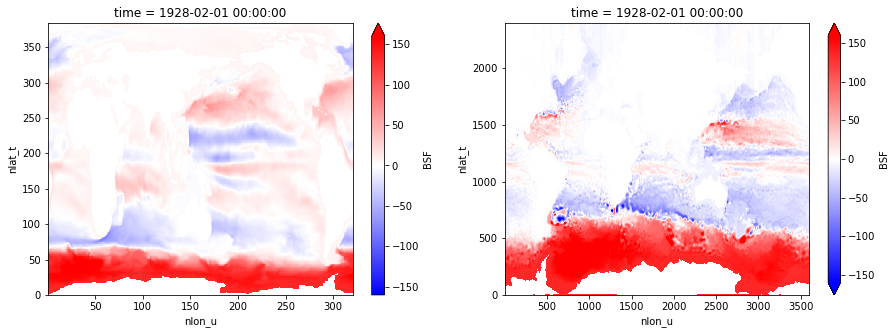

In [36]:
fig, axs= plt.subplots(1,2,figsize=(15,5))
# compare barotropic stream between LR and HR
(psi_TL+135).isel(time=0).where(mask_TL>0).plot(ax=axs[0],vmin=-160,vmax=160,cmap='bwr') 
# you can add psi any constant
(psi_TH+135).isel(time=0).where(mask_TH>0).plot(ax=axs[1],vmin=-160,vmax=160,cmap='bwr') 